In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [3]:
student_data=pd.read_csv('processed_student_data.csv')

In [5]:
# Suppose your target column is named 'Target'
X = student_data.drop('Target', axis=1)  # all columns except target
y = student_data['Target']               # only the target column

In [6]:
# IMPORTANT: Split BEFORE resampling to avoid data leakage
# We only apply resampling to the training set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nBefore Resampling:")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training set class distribution: {Counter(y_train)}")
print(f"Test set class distribution: {Counter(y_test)}")


Before Resampling:
Training set size: 2523
Test set size: 631
Training set class distribution: Counter({0: 1597, 1: 926})
Test set class distribution: Counter({0: 400, 1: 231})


In [7]:
# Apply Random Over Sampling ONLY to training data to prevent data leakage
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

print(f"\nAfter Resampling (Training Set Only):")
print(f"Balanced training set size: {X_train_balanced.shape[0]}")
print(f"Balanced training class distribution: {sorted(Counter(y_train_balanced).items())}")
print(f"Test set remains unchanged: {X_test.shape[0]}")


After Resampling (Training Set Only):
Balanced training set size: 3194
Balanced training class distribution: [(0, 1597), (1, 1597)]
Test set remains unchanged: 631


In [8]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit on balanced training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to preserve feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nData normalization completed (AFTER resampling)!")
print(f"Training data mean: {X_train_scaled.mean().mean():.6f}")
print(f"Training data std: {X_train_scaled.std().mean():.6f}")
print(f"Test data mean: {X_test_scaled.mean().mean():.6f}")
print(f"Test data std: {X_test_scaled.std().mean():.6f}")


Data normalization completed (AFTER resampling)!
Training data mean: -0.000000
Training data std: 1.000157
Test data mean: 0.028198
Test data std: 0.978082


In [9]:
# BLOCK 6: UTILITY FUNCTION FOR MODEL EVALUATION
# ============================================================================

def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    """
    Comprehensive model evaluation function
    Returns metrics and creates visualizations
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {model_name}")
    print(f"{'='*80}\n")
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Cross-validation scores (5-fold)
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
    cv_f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    
    # Print metrics
    print("ACCURACY SCORES:")
    print(f"  Training Accuracy:   {train_accuracy:.4f}")
    print(f"  Test Accuracy:       {test_accuracy:.4f}")
    print(f"  CV Accuracy (mean):  {cv_accuracy.mean():.4f} (+/- {cv_accuracy.std():.4f})")
    
    print("\nPRECISION SCORES:")
    print(f"  Training Precision:  {train_precision:.4f}")
    print(f"  Test Precision:      {test_precision:.4f}")
    
    print("\nRECALL SCORES:")
    print(f"  Training Recall:     {train_recall:.4f}")
    print(f"  Test Recall:         {test_recall:.4f}")
    print(f"  CV Recall (mean):    {cv_recall.mean():.4f} (+/- {cv_recall.std():.4f})")
    
    print("\nF1 SCORES:")
    print(f"  Training F1:         {train_f1:.4f}")
    print(f"  Test F1:             {test_f1:.4f}")
    print(f"  CV F1 (mean):        {cv_f1.mean():.4f} (+/- {cv_f1.std():.4f})")
    
    # Error rates (1 - accuracy as proxy for loss)
    train_error = 1 - train_accuracy
    test_error = 1 - test_accuracy
    cv_error = 1 - cv_accuracy.mean()
    
    print("\nERROR RATES (1 - Accuracy):")
    print(f"  Training Error:      {train_error:.4f}")
    print(f"  Test Error:          {test_error:.4f}")
    print(f"  CV Error (mean):     {cv_error:.4f}")
    
    # Classification Report
    print("\nCLASSIFICATION REPORT (Test Set):")
    print(classification_report(y_test, y_test_pred, 
                                target_names=['Graduate', 'Dropout']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{model_name} - Performance Metrics', fontsize=16, fontweight='bold')
    
    # 1. Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=['Graduate', 'Dropout'],
                yticklabels=['Graduate', 'Dropout'])
    axes[0, 0].set_title('Confusion Matrix (Test Set)')
    axes[0, 0].set_ylabel('True Label')
    axes[0, 0].set_xlabel('Predicted Label')
    
    # 2. Metrics Comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    train_scores = [train_accuracy, train_precision, train_recall, train_f1]
    test_scores = [test_accuracy, test_precision, test_recall, test_f1]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    axes[0, 1].bar(x - width/2, train_scores, width, label='Training', alpha=0.8)
    axes[0, 1].bar(x + width/2, test_scores, width, label='Test', alpha=0.8)
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('Training vs Test Metrics')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(metrics, rotation=45)
    axes[0, 1].legend()
    axes[0, 1].set_ylim([0, 1])
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. Cross-Validation Scores
    cv_metrics = ['Accuracy', 'Recall', 'F1 Score']
    cv_means = [cv_accuracy.mean(), cv_recall.mean(), cv_f1.mean()]
    cv_stds = [cv_accuracy.std(), cv_recall.std(), cv_f1.std()]
    
    axes[1, 0].bar(cv_metrics, cv_means, alpha=0.8, color='green')
    axes[1, 0].errorbar(cv_metrics, cv_means, yerr=cv_stds, 
                        fmt='none', color='black', capsize=5)
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Cross-Validation Scores (5-Fold)')
    axes[1, 0].set_ylim([0, 1])
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 4. Error Rates
    error_types = ['Training', 'Test', 'CV (mean)']
    error_values = [train_error, test_error, cv_error]
    colors = ['blue', 'orange', 'green']
    
    axes[1, 1].bar(error_types, error_values, alpha=0.8, color=colors)
    axes[1, 1].set_ylabel('Error Rate')
    axes[1, 1].set_title('Error Rates Comparison')
    axes[1, 1].set_ylim([0, max(error_values) * 1.2])
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Store results
    results = {
        'Model': model_name,
        'Train_Accuracy': train_accuracy,
        'Test_Accuracy': test_accuracy,
        'CV_Accuracy': cv_accuracy.mean(),
        'Train_Precision': train_precision,
        'Test_Precision': test_precision,
        'Train_Recall': train_recall,
        'Test_Recall': test_recall,
        'CV_Recall': cv_recall.mean(),
        'Train_F1': train_f1,
        'Test_F1': test_f1,
        'CV_F1': cv_f1.mean(),
        'Train_Error': train_error,
        'Test_Error': test_error,
        'CV_Error': cv_error
    }
    
    return results

print("\nEvaluation function defined successfully!")



Evaluation function defined successfully!



TRAINING K-NEAREST NEIGHBORS (KNN)

Hyperparameter Grid:
{'n_neighbors': [3, 5, 7, 9, 11, 15, 20], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}

Performing Grid Search (optimizing for Recall)...
Fitting 5 folds for each of 42 candidates, totalling 210 fits

Best Parameters:
{'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}

Best Cross-Validation Recall Score: 0.9337

EVALUATING: K-Nearest Neighbors (KNN)

ACCURACY SCORES:
  Training Accuracy:   1.0000
  Test Accuracy:       0.8780
  CV Accuracy (mean):  0.9421 (+/- 0.0334)

PRECISION SCORES:
  Training Precision:  1.0000
  Test Precision:      0.8775

RECALL SCORES:
  Training Recall:     1.0000
  Test Recall:         0.7749
  CV Recall (mean):    0.9337 (+/- 0.0554)

F1 SCORES:
  Training F1:         1.0000
  Test F1:             0.8230
  CV F1 (mean):        0.9409 (+/- 0.0347)

ERROR RATES (1 - Accuracy):
  Training Error:      0.0000
  Test Error:          0.1220
  CV Error

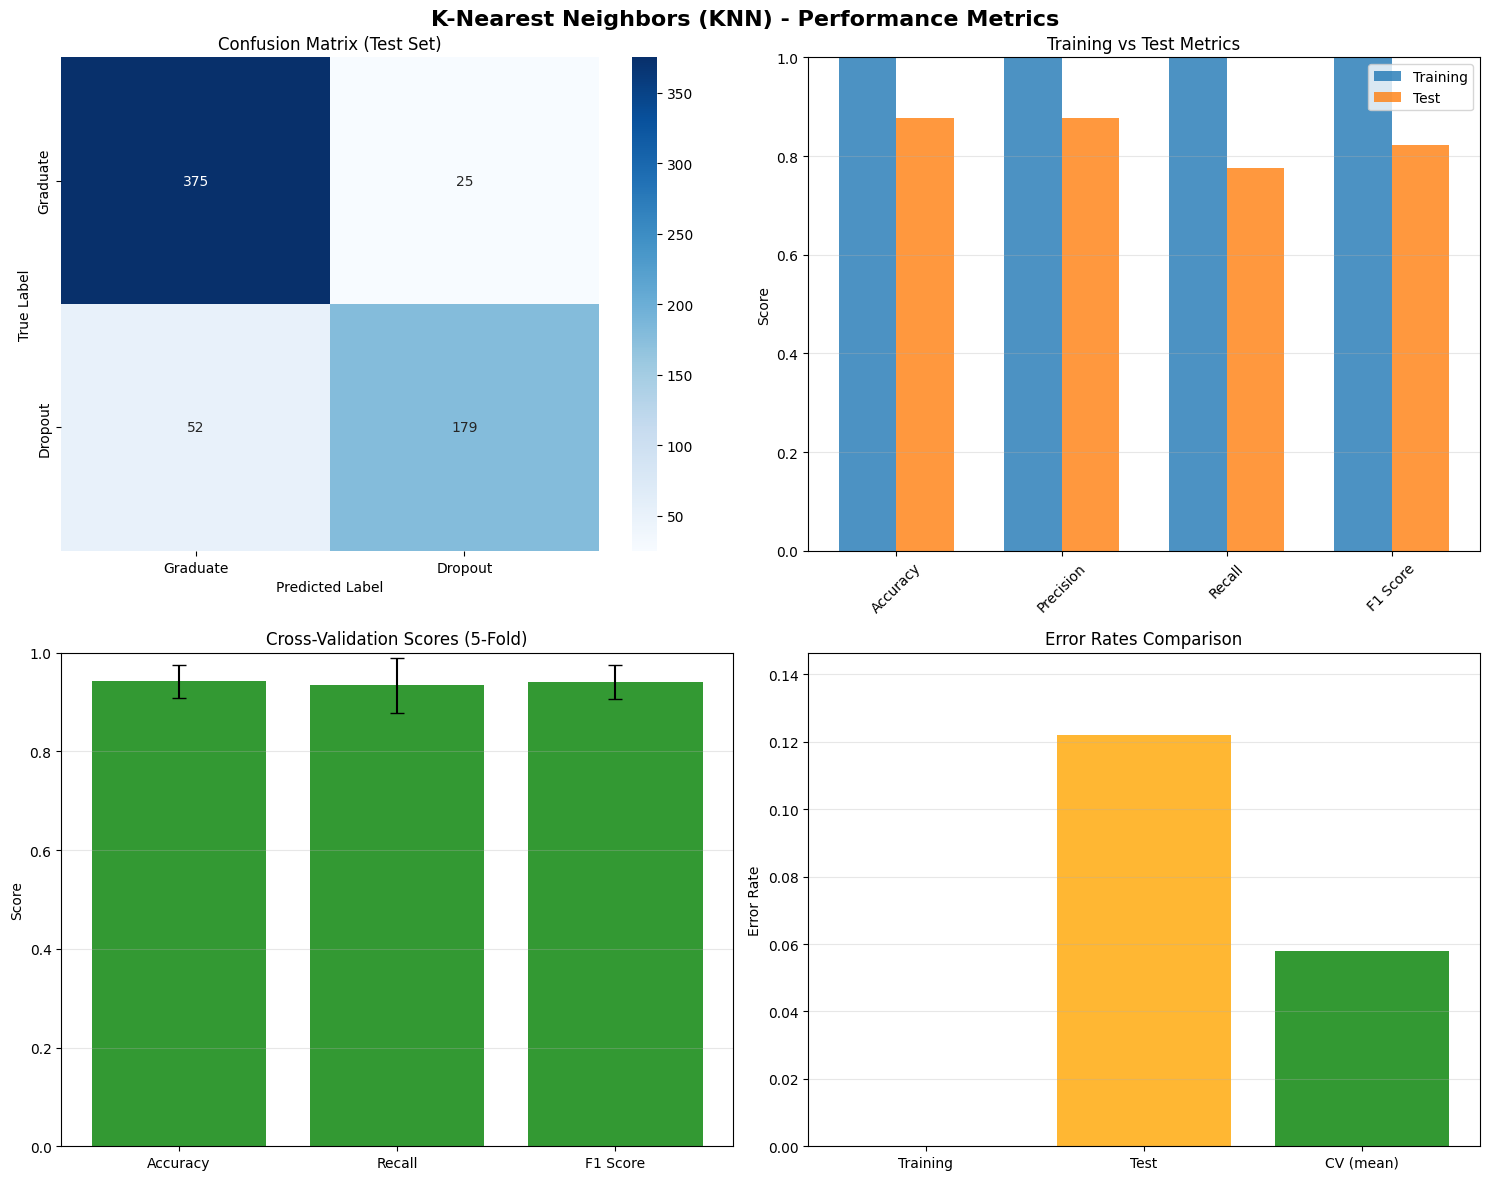

In [10]:
# ============================================================================
# BLOCK 7: K-NEAREST NEIGHBORS (KNN)
# ============================================================================

print("\n" + "="*80)
print("TRAINING K-NEAREST NEIGHBORS (KNN)")
print("="*80)

# Define hyperparameter grid for KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

print("\nHyperparameter Grid:")
print(knn_param_grid)

# Initialize KNN
knn = KNeighborsClassifier()

# Perform Grid Search with Cross-Validation (focusing on Recall)
print("\nPerforming Grid Search (optimizing for Recall)...")
knn_grid = GridSearchCV(
    estimator=knn,
    param_grid=knn_param_grid,
    cv=5,
    scoring='recall',  # Focus on recall
    n_jobs=-1,
    verbose=1
)

# Fit the model
knn_grid.fit(X_train_scaled, y_train_balanced)

# Best parameters
print("\nBest Parameters:")
print(knn_grid.best_params_)
print(f"\nBest Cross-Validation Recall Score: {knn_grid.best_score_:.4f}")

# Get the best model
best_knn = knn_grid.best_estimator_

# Evaluate the model
knn_results = evaluate_model(
    model=best_knn,
    model_name="K-Nearest Neighbors (KNN)",
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    y_train=y_train_balanced,
    y_test=y_test
)


TRAINING LOGISTIC REGRESSION

Hyperparameter Grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga'], 'max_iter': [1000]}

Performing Grid Search (optimizing for Recall)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters:
{'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}

Best Cross-Validation Recall Score: 0.8704

EVALUATING: Logistic Regression

ACCURACY SCORES:
  Training Accuracy:   0.8998
  Test Accuracy:       0.9097
  CV Accuracy (mean):  0.8945 (+/- 0.0133)

PRECISION SCORES:
  Training Precision:  0.9181
  Test Precision:      0.8783

RECALL SCORES:
  Training Recall:     0.8779
  Test Recall:         0.8745
  CV Recall (mean):    0.8704 (+/- 0.0120)

F1 SCORES:
  Training F1:         0.8976
  Test F1:             0.8764
  CV F1 (mean):        0.8920 (+/- 0.0125)

ERROR RATES (1 - Accuracy):
  Training Error:      0.1002
  Test Error:          0.0903
  CV Error (mean):     0.1055

CLASSIFI

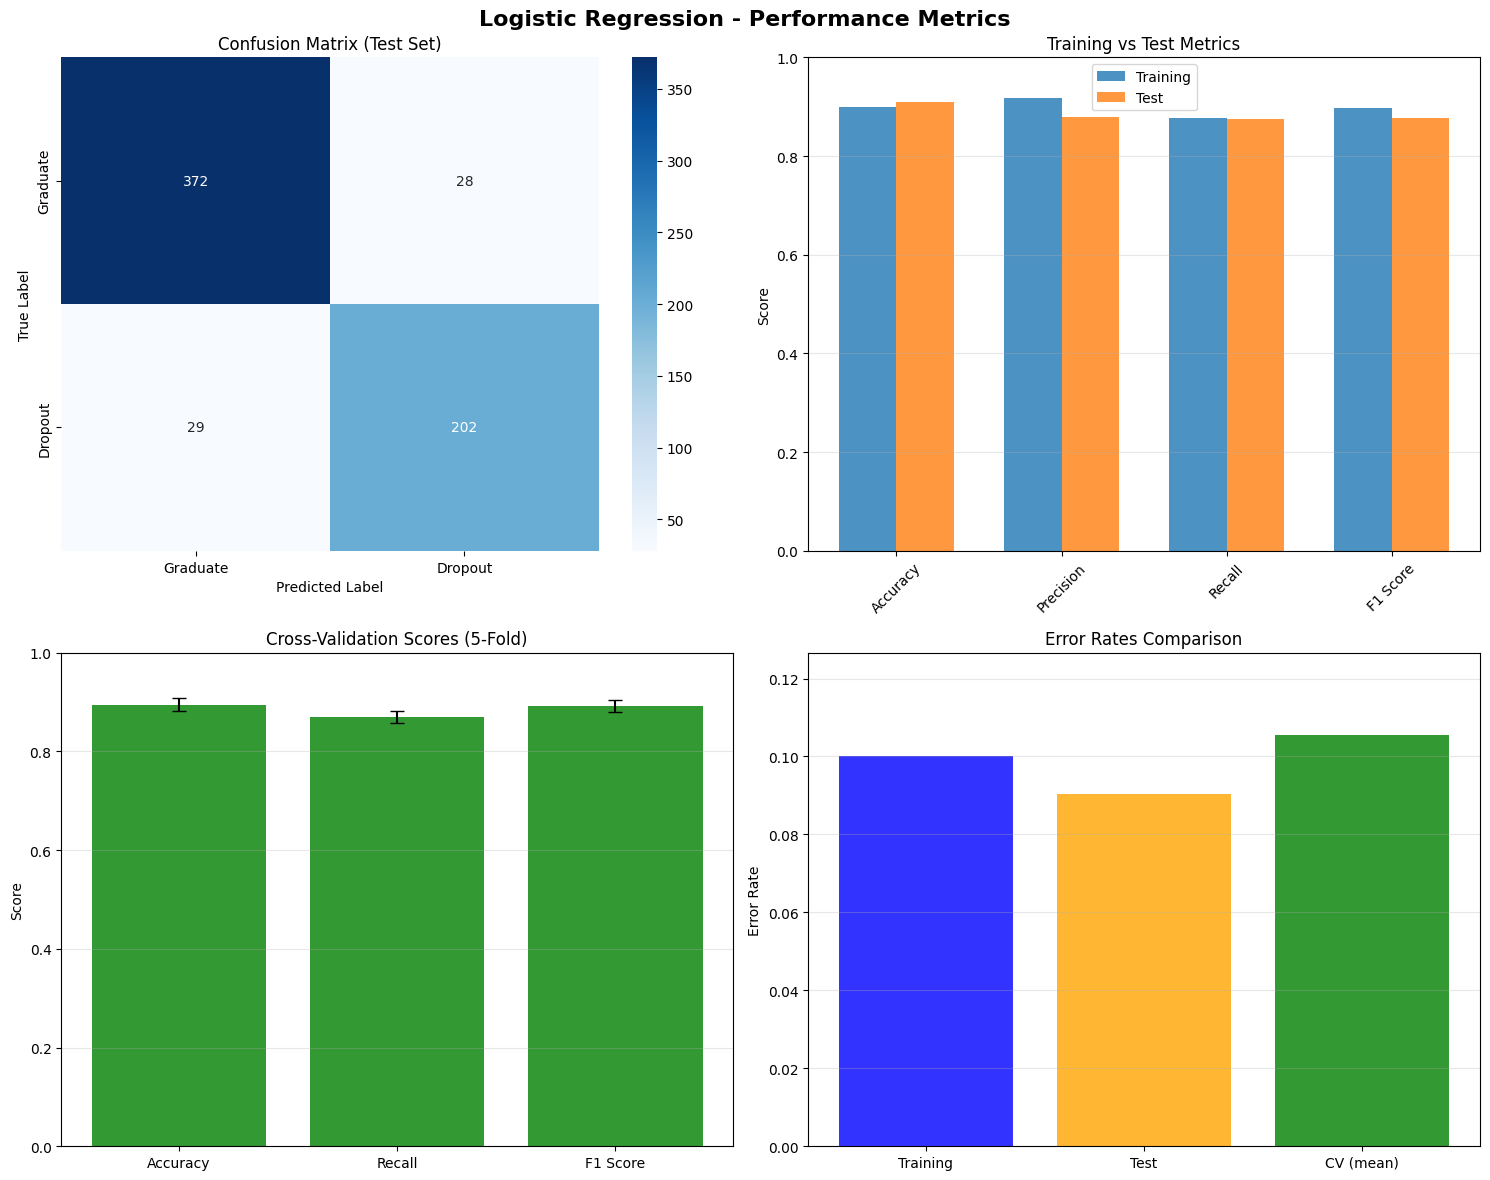

In [11]:
# ============================================================================
# BLOCK 8: LOGISTIC REGRESSION
# ============================================================================

print("\n" + "="*80)
print("TRAINING LOGISTIC REGRESSION")
print("="*80)

# Define hyperparameter grid for Logistic Regression
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

print("\nHyperparameter Grid:")
print(lr_param_grid)

# Initialize Logistic Regression
lr = LogisticRegression(random_state=42)

# Perform Grid Search with Cross-Validation (focusing on Recall)
print("\nPerforming Grid Search (optimizing for Recall)...")
lr_grid = GridSearchCV(
    estimator=lr,
    param_grid=lr_param_grid,
    cv=5,
    scoring='recall',  # Focus on recall
    n_jobs=-1,
    verbose=1
)

# Fit the model
lr_grid.fit(X_train_scaled, y_train_balanced)

# Best parameters
print("\nBest Parameters:")
print(lr_grid.best_params_)
print(f"\nBest Cross-Validation Recall Score: {lr_grid.best_score_:.4f}")

# Get the best model
best_lr = lr_grid.best_estimator_

# Evaluate the model
lr_results = evaluate_model(
    model=best_lr,
    model_name="Logistic Regression",
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    y_train=y_train_balanced,
    y_test=y_test
)



TRAINING SUPPORT VECTOR MACHINE (SVM)

Hyperparameter Grid:
{'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]}

Performing Grid Search (optimizing for Recall)...
Note: SVM training may take longer...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best Parameters:
{'C': 10, 'gamma': 0.001, 'kernel': 'poly'}

Best Cross-Validation Recall Score: 0.9906

EVALUATING: Support Vector Machine (SVM)

ACCURACY SCORES:
  Training Accuracy:   0.5138
  Test Accuracy:       0.3819
  CV Accuracy (mean):  0.5103 (+/- 0.0042)

PRECISION SCORES:
  Training Precision:  0.5070
  Test Precision:      0.3707

RECALL SCORES:
  Training Recall:     0.9912
  Test Recall:         0.9870
  CV Recall (mean):    0.9906 (+/- 0.0056)

F1 SCORES:
  Training F1:         0.6709
  Test F1:             0.5390
  CV F1 (mean):        0.6692 (+/- 0.0028)

ERROR RATES (1 - Accuracy):
  Training Error:      0.4862
  Test Error:          0.6181
  CV Erro

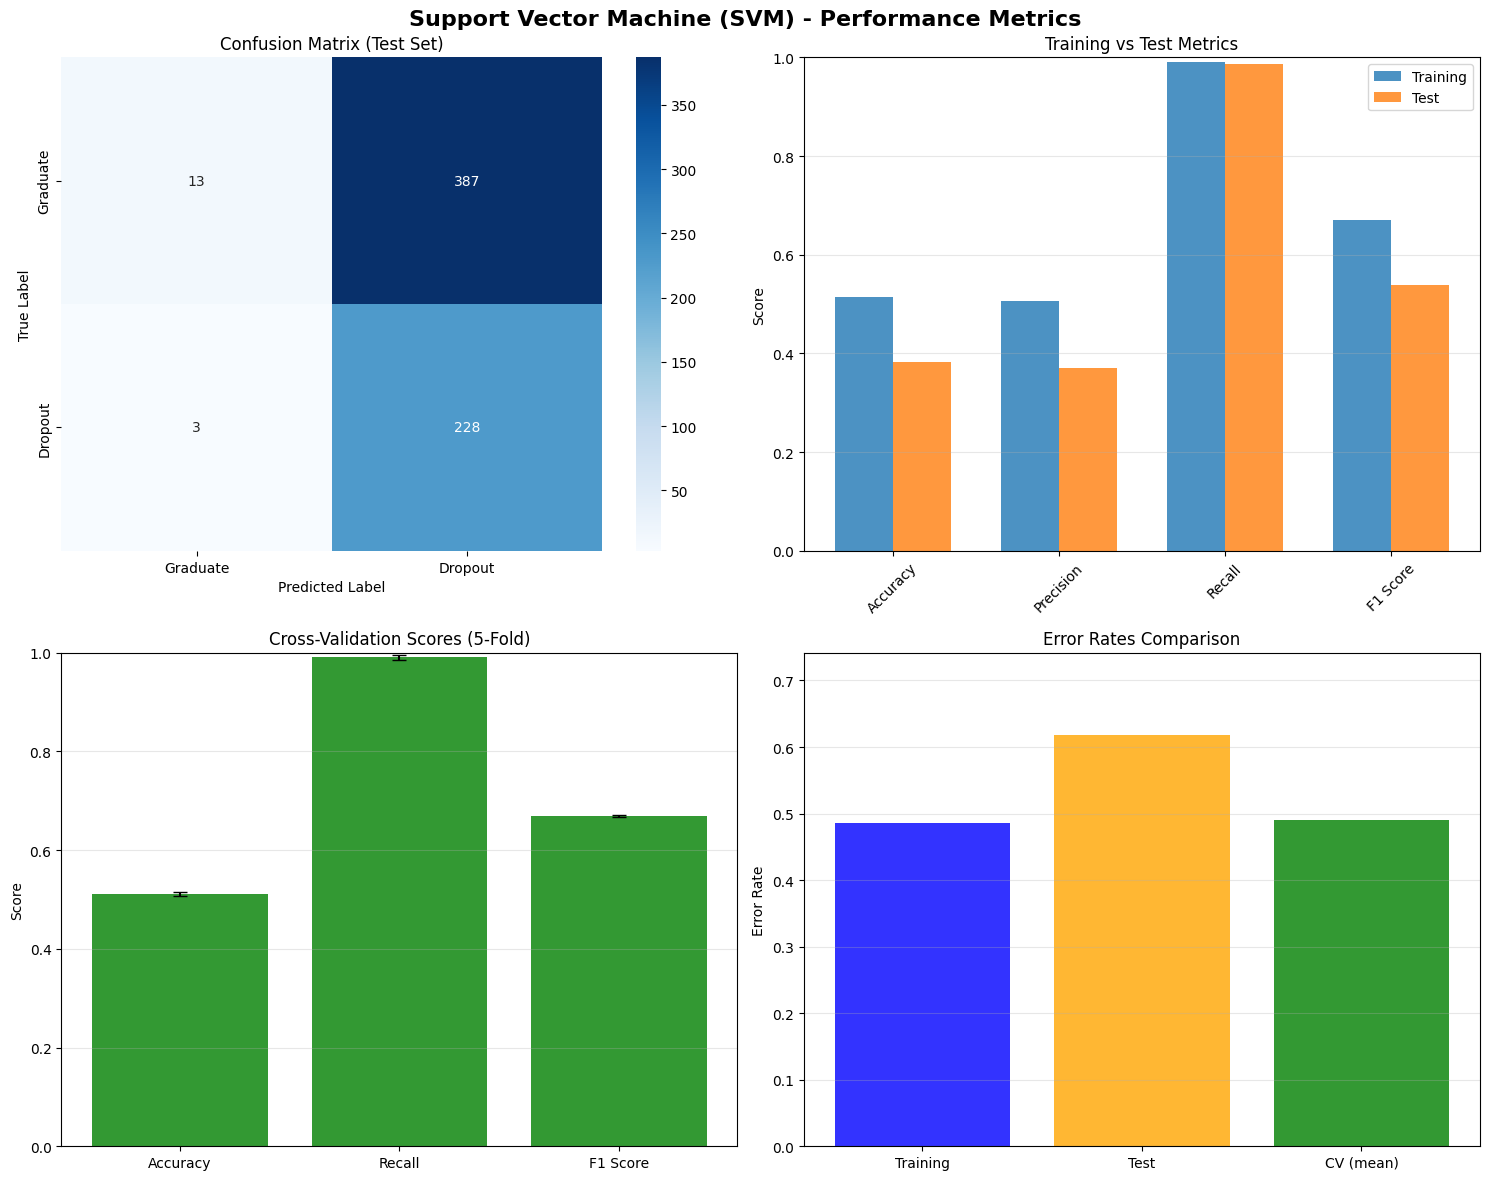

In [12]:
# ============================================================================
# BLOCK 9: SUPPORT VECTOR MACHINE (SVM)
# ============================================================================

print("\n" + "="*80)
print("TRAINING SUPPORT VECTOR MACHINE (SVM)")
print("="*80)

# Define hyperparameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

print("\nHyperparameter Grid:")
print(svm_param_grid)

# Initialize SVM
svm = SVC(random_state=42)

# Perform Grid Search with Cross-Validation (focusing on Recall)
print("\nPerforming Grid Search (optimizing for Recall)...")
print("Note: SVM training may take longer...")
svm_grid = GridSearchCV(
    estimator=svm,
    param_grid=svm_param_grid,
    cv=5,
    scoring='recall',  # Focus on recall
    n_jobs=-1,
    verbose=1
)

# Fit the model
svm_grid.fit(X_train_scaled, y_train_balanced)

# Best parameters
print("\nBest Parameters:")
print(svm_grid.best_params_)
print(f"\nBest Cross-Validation Recall Score: {svm_grid.best_score_:.4f}")

# Get the best model
best_svm = svm_grid.best_estimator_

# Evaluate the model
svm_results = evaluate_model(
    model=best_svm,
    model_name="Support Vector Machine (SVM)",
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    y_train=y_train_balanced,
    y_test=y_test
)


TRAINING DECISION TREE

Hyperparameter Grid:
{'max_depth': [3, 5, 7, 10, 15, 20, None], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [1, 2, 4, 8], 'criterion': ['gini', 'entropy']}

Performing Grid Search (optimizing for Recall)...
Fitting 5 folds for each of 224 candidates, totalling 1120 fits

Best Parameters:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best Cross-Validation Recall Score: 0.9437

EVALUATING: Decision Tree

ACCURACY SCORES:
  Training Accuracy:   1.0000
  Test Accuracy:       0.8685
  CV Accuracy (mean):  0.9136 (+/- 0.0207)

PRECISION SCORES:
  Training Precision:  1.0000
  Test Precision:      0.8304

RECALL SCORES:
  Training Recall:     1.0000
  Test Recall:         0.8052
  CV Recall (mean):    0.9437 (+/- 0.0461)

F1 SCORES:
  Training F1:         1.0000
  Test F1:             0.8176
  CV F1 (mean):        0.9157 (+/- 0.0217)

ERROR RATES (1 - Accuracy):
  Training Error:      0.0000
  Test Error:     

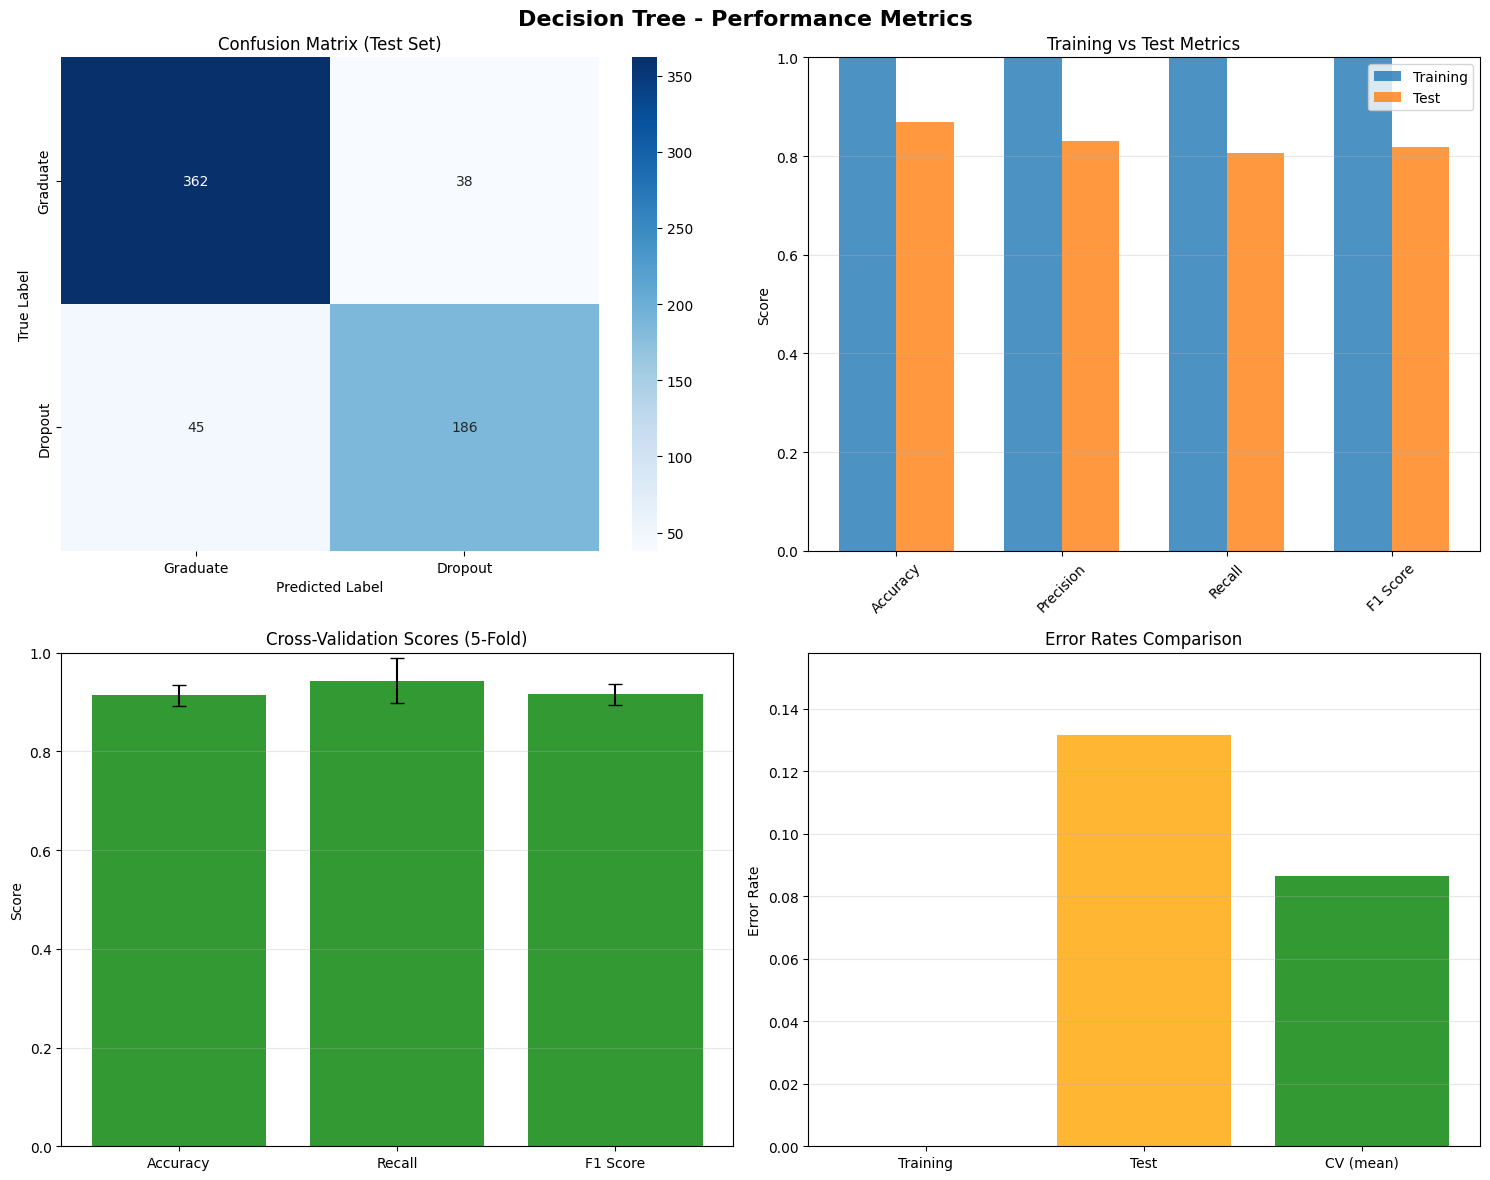

In [13]:
# ============================================================================
# BLOCK 10: DECISION TREE
# ============================================================================

print("\n" + "="*80)
print("TRAINING DECISION TREE")
print("="*80)

# Define hyperparameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

print("\nHyperparameter Grid:")
print(dt_param_grid)

# Initialize Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Perform Grid Search with Cross-Validation (focusing on Recall)
print("\nPerforming Grid Search (optimizing for Recall)...")
dt_grid = GridSearchCV(
    estimator=dt,
    param_grid=dt_param_grid,
    cv=5,
    scoring='recall',  # Focus on recall
    n_jobs=-1,
    verbose=1
)

# Fit the model
dt_grid.fit(X_train_scaled, y_train_balanced)

# Best parameters
print("\nBest Parameters:")
print(dt_grid.best_params_)
print(f"\nBest Cross-Validation Recall Score: {dt_grid.best_score_:.4f}")

# Get the best model
best_dt = dt_grid.best_estimator_

# Evaluate the model
dt_results = evaluate_model(
    model=best_dt,
    model_name="Decision Tree",
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    y_train=y_train_balanced,
    y_test=y_test
)



FINAL MODEL COMPARISON

Complete Results Table:
                       Model  Train_Accuracy  Test_Accuracy  CV_Accuracy  Train_Precision  Test_Precision  Train_Recall  Test_Recall  CV_Recall  Train_F1  Test_F1    CV_F1  Train_Error  Test_Error  CV_Error
   K-Nearest Neighbors (KNN)        1.000000       0.877971     0.942090         1.000000        0.877451      1.000000     0.774892   0.933693  1.000000 0.822989 0.940871     0.000000    0.122029  0.057910
         Logistic Regression        0.899812       0.909667     0.894491         0.918140        0.878261      0.877896     0.874459   0.870396  0.897567 0.876356 0.892000     0.100188    0.090333  0.105509
Support Vector Machine (SVM)        0.513776       0.381933     0.510333         0.507047        0.370732      0.991234     0.987013   0.990613  0.670905 0.539007 0.669205     0.486224    0.618067  0.489667
               Decision Tree        1.000000       0.868463     0.913591         1.000000        0.830357      1.000000    

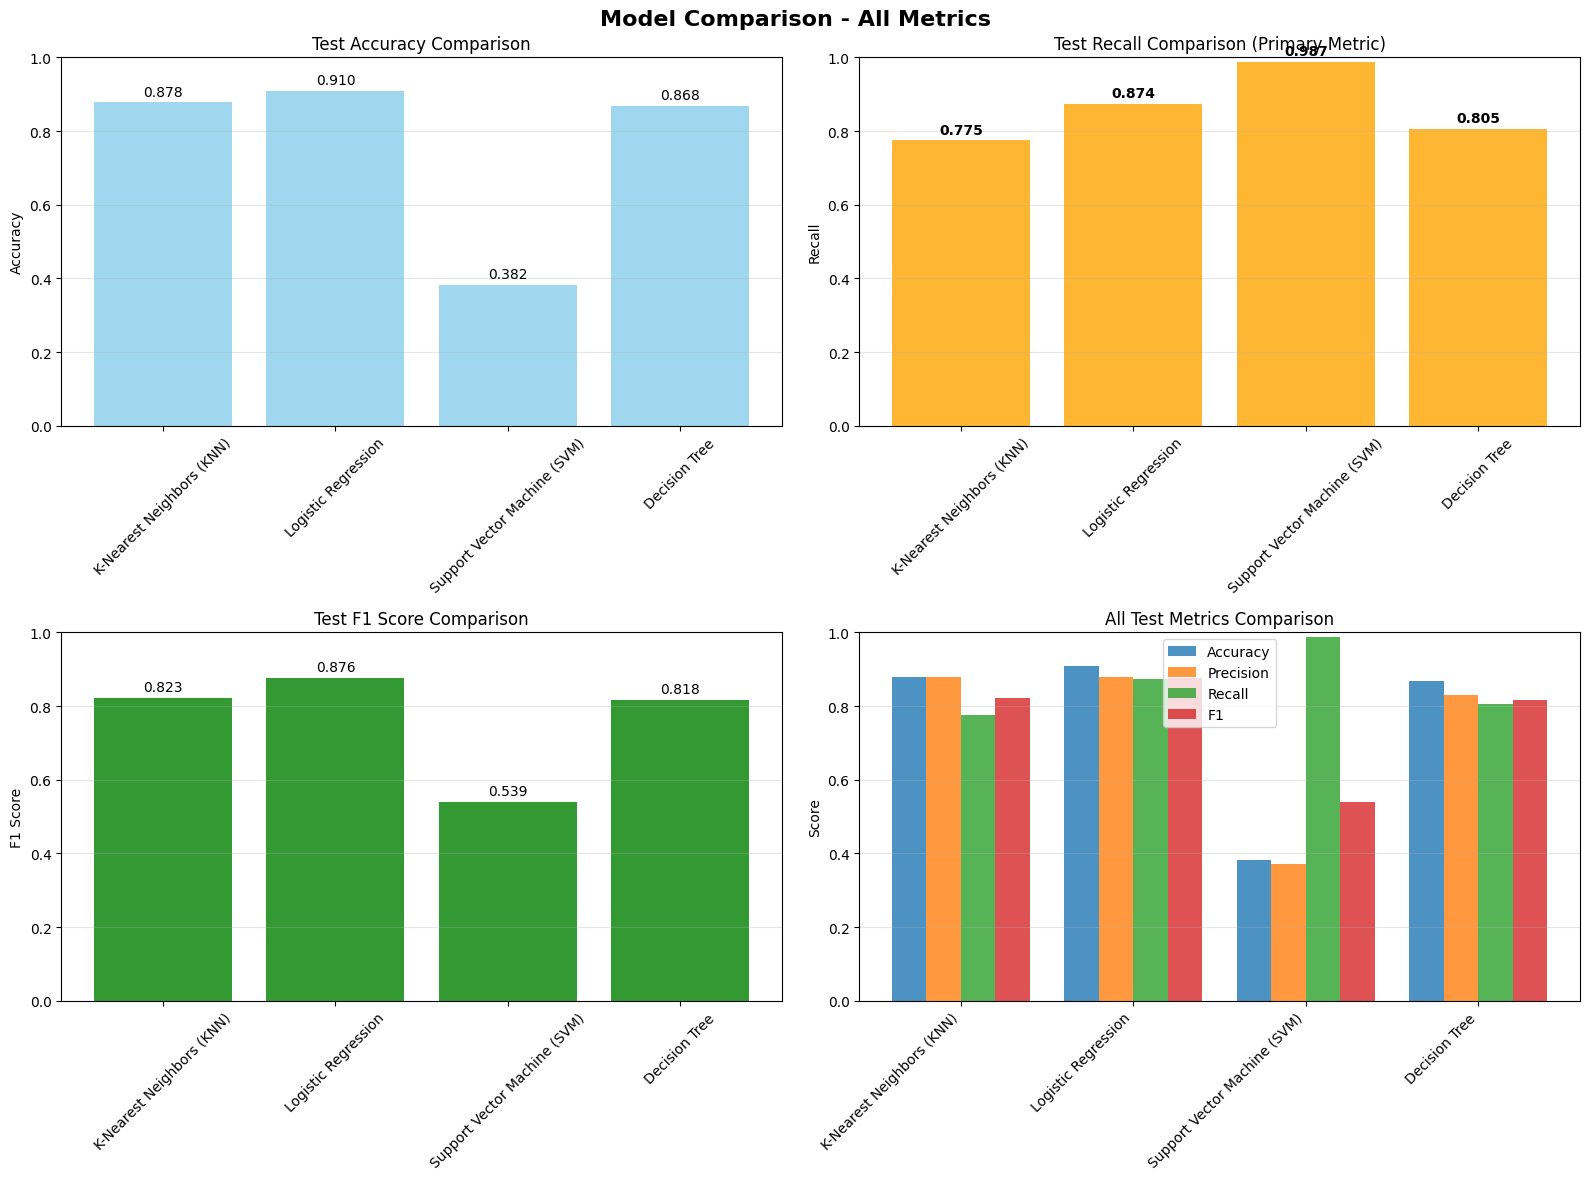


BEST PERFORMING MODELS

Best Model (Recall):    Support Vector Machine (SVM) - 0.9870
Best Model (F1 Score):  Logistic Regression - 0.8764
Best Model (Accuracy):  Logistic Regression - 0.9097

MODEL TRAINING AND EVALUATION COMPLETE!


In [14]:
# ============================================================================
# BLOCK 11: MODEL COMPARISON
# ============================================================================

print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)

# Compile all results
all_results = pd.DataFrame([knn_results, lr_results, svm_results, dt_results])

print("\nComplete Results Table:")
print(all_results.to_string(index=False))

# Create comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Comparison - All Metrics', fontsize=16, fontweight='bold')

# 1. Test Accuracy Comparison
axes[0, 0].bar(all_results['Model'], all_results['Test_Accuracy'], alpha=0.8, color='skyblue')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Test Accuracy Comparison')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(all_results['Test_Accuracy']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 2. Test Recall Comparison (Primary Focus)
axes[0, 1].bar(all_results['Model'], all_results['Test_Recall'], alpha=0.8, color='orange')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_title('Test Recall Comparison (Primary Metric)')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(all_results['Test_Recall']):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Test F1 Score Comparison
axes[1, 0].bar(all_results['Model'], all_results['Test_F1'], alpha=0.8, color='green')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('Test F1 Score Comparison')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(all_results['Test_F1']):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 4. Multiple Metrics Grouped
x = np.arange(len(all_results))
width = 0.2

axes[1, 1].bar(x - 1.5*width, all_results['Test_Accuracy'], width, label='Accuracy', alpha=0.8)
axes[1, 1].bar(x - 0.5*width, all_results['Test_Precision'], width, label='Precision', alpha=0.8)
axes[1, 1].bar(x + 0.5*width, all_results['Test_Recall'], width, label='Recall', alpha=0.8)
axes[1, 1].bar(x + 1.5*width, all_results['Test_F1'], width, label='F1', alpha=0.8)

axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('All Test Metrics Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(all_results['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Identify best models
best_recall_model = all_results.loc[all_results['Test_Recall'].idxmax(), 'Model']
best_f1_model = all_results.loc[all_results['Test_F1'].idxmax(), 'Model']
best_accuracy_model = all_results.loc[all_results['Test_Accuracy'].idxmax(), 'Model']

print("\n" + "="*80)
print("BEST PERFORMING MODELS")
print("="*80)
print(f"\nBest Model (Recall):    {best_recall_model} - {all_results.loc[all_results['Test_Recall'].idxmax(), 'Test_Recall']:.4f}")
print(f"Best Model (F1 Score):  {best_f1_model} - {all_results.loc[all_results['Test_F1'].idxmax(), 'Test_F1']:.4f}")
print(f"Best Model (Accuracy):  {best_accuracy_model} - {all_results.loc[all_results['Test_Accuracy'].idxmax(), 'Test_Accuracy']:.4f}")

print("\n" + "="*80)
print("MODEL TRAINING AND EVALUATION COMPLETE!")
print("="*80)

# Model Training Summary - Phase 1 Results

## Performance Comparison (All Models)

| Model | Test Accuracy | Test Recall | Test F1-Score | Test Precision |
|-------|---------------|-------------|---------------|----------------|
| **KNN** | 0.878 | 0.775 | 0.823 | 0.877 |
| **Logistic Regression** | **0.910** | 0.874 | **0.876** | 0.878 |
| **SVM** | 0.382 | **0.997** | 0.539 | 0.371 |
| **Decision Tree** | 0.868 | 0.805 | 0.818 | 0.831 |

---

## Key Findings

### 🏆 Best Overall Model: **Logistic Regression**
- **Highest Accuracy**: 91.0%
- **Balanced Performance**: Good recall (87.4%) + Good precision (87.8%)
- **Best F1-Score**: 0.876
- **Why Best**: Excellent balance between catching dropouts and avoiding false alarms

### 🎯 Best Recall: **SVM** (99.7%)
- Catches almost ALL dropout students
- **BUT**: Very poor precision (37.1%) - too many false alarms
- **Issue**: Flags most students as dropouts (not practical)
- Not recommended due to poor overall accuracy (38.2%)

### 📊 Model Rankings

**By Overall Performance:**
1. ✅ **Logistic Regression** - Best balanced model
2. Decision Tree - Good but slight overfitting
3. KNN - Decent performance
4. SVM - Not usable (too many false positives)

**By Recall (Catching Dropouts):**
1. SVM - 99.7% (but unusable)
2. Logistic Regression - 87.4% ✅ **Best practical choice**
3. Decision Tree - 80.5%
4. KNN - 77.5%

---

## Summary of Issues

### Problems with Current Approach:
1. **SVM overfits to minority class** - predicts almost everything as dropout
2. **KNN has lowest recall** - misses 22.5% of dropout students
3. **All models miss 13-23%** of dropout students (except unusable SVM)
4. **Using all 36 features** - may include noise and irrelevant data

---

## Phase 2: Improvement Plan 🚀

### 1. **Better Class Balancing**
- **Replace**: Random Over Sampling
- **Use**: SMOTE (Synthetic Minority Over-sampling)
- **Also Try**: ADASYN, Tomek Links, SMOTETomek
- **Expected**: +5% recall, better model generalization

### 2. **Advanced Models**
Test ensemble methods that handle imbalance better:
- ✅ **Random Forest** - Reduces overfitting, handles interactions
- ✅ **XGBoost** - Best for imbalanced data, built-in regularization
- ✅ **LightGBM** - Faster training, good performance
- ✅ **CatBoost** - Handles features automatically
- ✅ **Voting Ensemble** - Combine Logistic Regression + Random Forest

### 3. **Feature Selection/Reduction**
Reduce from 36 features to most important ones:
- **Method 1**: PCA (Principal Component Analysis)
  - Reduce to 15-20 components
  - Retain 95% variance
- **Method 2**: Feature Importance from Random Forest/XGBoost
  - Select top 15 most important features
  - Remove noise and redundant features
- **Method 3**: Recursive Feature Elimination (RFE)
  - Systematically remove least useful features

**Expected Benefits**:
- Less overfitting
- Faster training
- Better generalization
- 2-5% improvement in metrics

---

## Proposed Pipeline for Phase 2

```
Step 1: Feature Selection
   ├── Train Random Forest on all 36 features
   ├── Get feature importance scores
   └── Select top 15-20 features

Step 2: Apply SMOTE
   ├── Split data (train/test)
   ├── Apply SMOTE to training data only
   └── Normalize features

Step 3: Train Advanced Models
   ├── Random Forest + GridSearch
   ├── XGBoost + GridSearch
   ├── LightGBM + GridSearch
   ├── CatBoost
   └── Ensemble (combine best 2-3 models)

Step 4: Compare & Select
   └── Choose model with best Recall + F1-Score
```

---

## Target Improvements for Phase 2

| Metric | Current Best | Phase 2 Target |
|--------|--------------|----------------|
| **Accuracy** | 91.0% (LR) | 92-94% |
| **Recall** | 87.4% (LR) | 90-93% |
| **F1-Score** | 0.876 (LR) | 0.90-0.92 |
| **Precision** | 87.8% (LR) | 88-92% |

**Goal**: Catch 90%+ of dropout students while maintaining high accuracy

---

## Conclusion

### Phase 1 Summary:
- ✅ **Logistic Regression is the best current model** (91% accuracy, 87.4% recall)
- ❌ SVM is unusable despite 99.7% recall (too many false positives)
- ⚠️ Still missing 12.6% of dropout students with best model

### Why We Need Phase 2:
1. **SMOTE** will create better synthetic samples (vs duplicating)
2. **Feature Selection** will remove noise and improve generalization
3. **Advanced Models** (XGBoost, Random Forest) handle imbalanced data better
4. **Ensemble Methods** can combine strengths of multiple models

### Expected Outcome:
- **90-93% recall** (catch 9 out of 10 dropout students)
- **92-94% accuracy** (better overall performance)
- **Less overfitting** (more reliable predictions)
- **Faster inference** (fewer features = faster predictions)

**Next Step**: Implement Phase 2 with SMOTE + Feature Selection + XGBoost/Random Forest